In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter
plt.style.use('seaborn')

# Soil and test blank spectra, 4/21/21, Green configuration

In this notebook I mostly examine stationary spectra that were collected on 4/21/21 of the white test blank and a moist soil sample.

I am primarily looking at the interaction between temperature and the calibration spectra.

For this reason, I also compare with some previously-collected data (towards the beginning of the notebook.)

In [2]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
test_file_name = "210401_tests/vis_ftir_test1.h5"
file = path_name + test_file_name

In [3]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
        

In [4]:
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertions = list(h5_file[calibration_path].keys())
        return insertions


# Stationary moist soil sample spectra from previous dates.

#### Lists for retrieving data from the 4/1/21 file.  All represent a moist soil sample. 

insertions_4_01 are the insertions for which the sample was held stationary.  insertions_4_01_moving are the insertions where the sample itself was gently moved, though the probe remained stationary.

In [5]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
test_file_name = "210401_tests/vis_ftir_test1.h5"
file = path_name + test_file_name
calibration_4_01 = ['session001/cal002']
insertions_4_01 = ['ins011', 'ins012', 'ins013', 'ins014', 'ins015']
insertions_4_01_moving = ['ins016', 'ins017', 'ins018', 'ins019', 'ins020']

In [6]:
cal_temp = get_calibration_temperature(file, calibration_4_01[0])
print(cal_temp)

2.6923738872865783


In [7]:
vis_waves = get_visible_wavelength_vector(file, calibration_4_01[0])
ftir_waves = get_ftir_wavelength_vector(file, calibration_4_01[0])

In [8]:
vis_cal = get_visible_white_calibration_curve(file, calibration_4_01[0])
ftir_cal = get_ftir_white_calibration_curve(file, calibration_4_01[0])

## Calibrations curves obtained 4/1/21

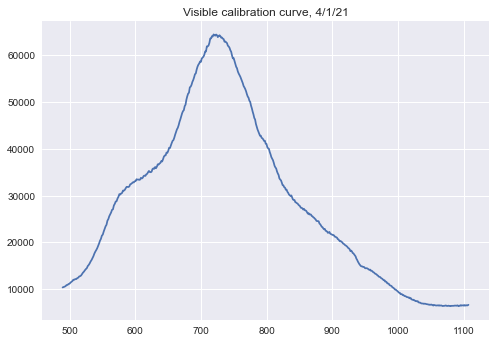

In [9]:
fig, ax = plt.subplots()
ax.set_title("Visible calibration curve, 4/1/21")
ax.plot(vis_waves, vis_cal)
plt.show()
plt.close()

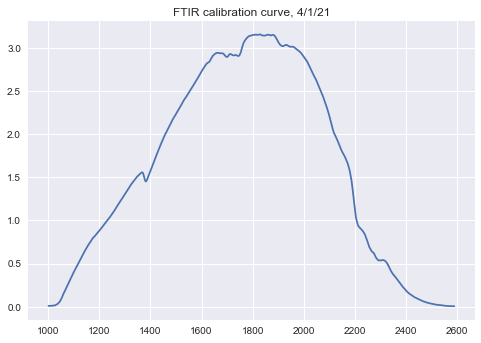

In [10]:
fig, ax = plt.subplots()
ax.set_title("FTIR calibration curve, 4/1/21")
ax.plot(ftir_waves, ftir_cal)
plt.show()
plt.close()

## Absorbance spectra (FTIR engine) of moist soil sample, obtained 4/1/21

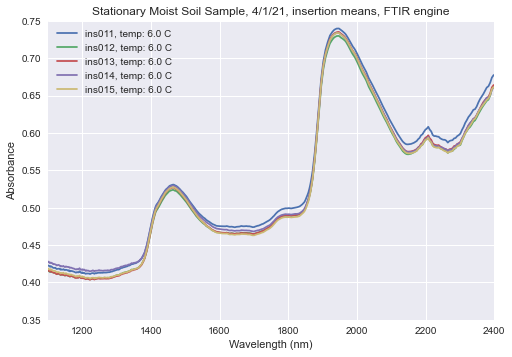

In [11]:
fig, ax = plt.subplots()
ax.set_ylim(0.35, 0.75)
ax.set_xlim(1100, 2400)
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
ax.set_title("Stationary Moist Soil Sample, 4/1/21, insertion means, FTIR engine")
for insertion in insertions_4_01:
    insertion_path = f'{calibration_4_01[0]}/{insertion}'
    ins_temp = get_insertion_temperature(file, insertion_path)
    label = f'{insertion}, temp: {ins_temp:0.1f} C'
    ins_abs = get_ftir_insertion_absorbances(file, insertion_path)
    ax.plot(ftir_waves, ins_abs.mean(axis=0), label=label)
ax.legend()
plt.show()
plt.close()
    

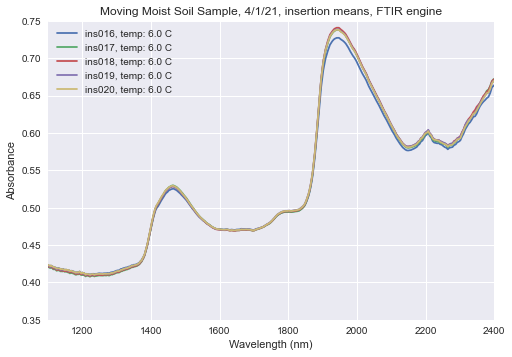

In [12]:
fig, ax = plt.subplots()
ax.set_ylim(0.35, 0.75)
ax.set_xlim(1100, 2400)
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
ax.set_title("Moving Moist Soil Sample, 4/1/21, insertion means, FTIR engine")
for insertion in insertions_4_01_moving:
    insertion_path = f'{calibration_4_01[0]}/{insertion}'
    ins_temp = get_insertion_temperature(file, insertion_path)
    label = f'{insertion}, temp: {ins_temp:0.1f} C'
    ins_abs = get_ftir_insertion_absorbances(file, insertion_path)
    ax.plot(ftir_waves, ins_abs.mean(axis=0), label=label)
ax.legend()
plt.show()
plt.close()

## Absorbance spectra (visible spectrometer) of moist soil sample, obtained 4/1/21

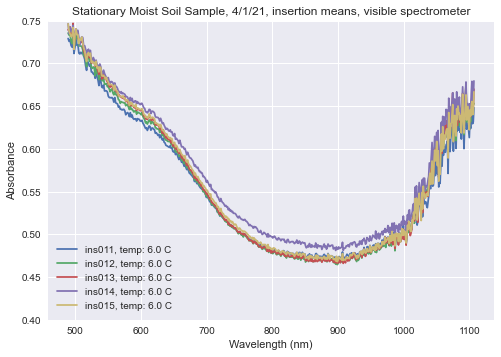

In [13]:
fig, ax = plt.subplots()
ax.set_ylim(0.4, 0.75)
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
ax.set_title("Stationary Moist Soil Sample, 4/1/21, insertion means, visible spectrometer")
for insertion in insertions_4_01:
    insertion_path = f'{calibration_4_01[0]}/{insertion}'
    ins_temp = get_insertion_temperature(file, insertion_path)
    label = f'{insertion}, temp: {ins_temp:0.1f} C'
    ins_abs = get_visible_insertion_absorbances(file, insertion_path)
    ax.plot(vis_waves, ins_abs.mean(axis=0), label=label)
ax.legend()
plt.show()
plt.close()

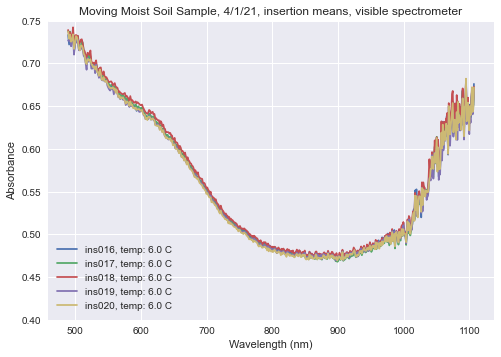

In [14]:
fig, ax = plt.subplots()
ax.set_ylim(0.4, 0.75)
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
ax.set_title("Moving Moist Soil Sample, 4/1/21, insertion means, visible spectrometer")
for insertion in insertions_4_01_moving:
    insertion_path = f'{calibration_4_01[0]}/{insertion}'
    ins_temp = get_insertion_temperature(file, insertion_path)
    label = f'{insertion}, temp: {ins_temp:0.1f} C'
    ins_abs = get_visible_insertion_absorbances(file, insertion_path)
    ax.plot(vis_waves, ins_abs.mean(axis=0), label=label)
ax.legend()
plt.show()
plt.close()

# Data obtained 4/9/21

Spectra of the stationary moist soil sample were also obtained on 4/9/21.

In [15]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
test_file_name = "210409_stationary_moving/blank_210409.h5"
file = path_name + test_file_name
calibration_4_09 = ['session003/cal001']
calibration_4_09_moving = ['session003/cal002']
insertions_4_09 = ['ins003', 'ins004', 'ins005']
insertions_4_09_moving = ['ins006', 'ins007', 'ins008']

In [16]:
cal_temp = get_calibration_temperature(file, calibration_4_09[0])
print(cal_temp)

27.89792262442006


In [17]:
cal_temp = get_calibration_temperature(file, calibration_4_09_moving[0])
print(cal_temp)

27.89792262442006


In [18]:
ins_temps = []
for insertion in insertions_4_09:
    insertion_path = f'{calibration_4_09[0]}/{insertion}'
    ins_temps.append(get_insertion_temperature(file, insertion_path))
print(ins_temps)
    

[28.135859613674086, 28.135859613674086, 28.135859613674086]


In [19]:
ins_temps = []
for insertion in insertions_4_09_moving:
    insertion_path = f'{calibration_4_09_moving[0]}/{insertion}'
    ins_temps.append(get_insertion_temperature(file, insertion_path))
print(ins_temps)

[29.108330331050695, 29.108330331050695, 29.108330331050695]


In [20]:
vis_waves = get_visible_wavelength_vector(file, calibration_4_09[0])
ftir_waves = get_ftir_wavelength_vector(file, calibration_4_09[0])

In [21]:
vis_cal = get_visible_white_calibration_curve(file, calibration_4_09[0])
ftir_cal = get_ftir_white_calibration_curve(file, calibration_4_09[0])
vis_cal_moving = get_visible_white_calibration_curve(file, calibration_4_09_moving[0])
ftir_cal_moving = get_ftir_white_calibration_curve(file, calibration_4_09_moving[0])


## Calibration curves obtained 4/9/21

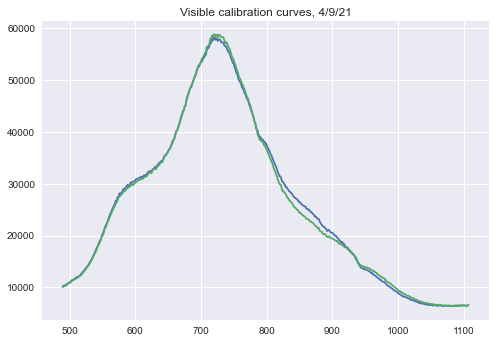

In [22]:
fig, ax = plt.subplots()
ax.set_title("Visible calibration curves, 4/9/21")
ax.plot(vis_waves, vis_cal)
ax.plot(vis_waves, vis_cal_moving)
plt.show()
plt.close()

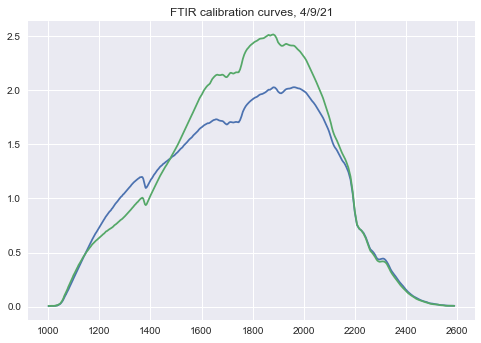

In [23]:
fig, ax = plt.subplots()
ax.set_title("FTIR calibration curves, 4/9/21")
ax.plot(ftir_waves, ftir_cal)
ax.plot(ftir_waves, ftir_cal_moving)
plt.show()
plt.close()

# Absorbance spectra of stationary moist soil sample, 4/9/21

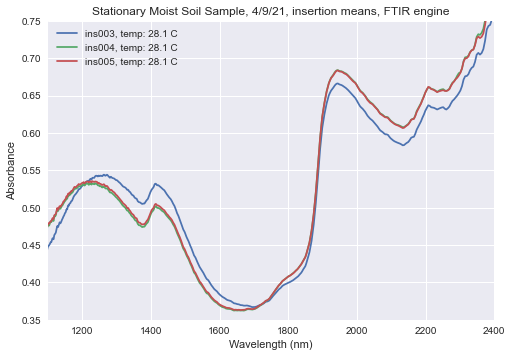

In [24]:
fig, ax = plt.subplots()
ax.set_ylim(0.35, 0.75)
ax.set_xlim(1100, 2400)
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
ax.set_title("Stationary Moist Soil Sample, 4/9/21, insertion means, FTIR engine")
for insertion in insertions_4_09:
    insertion_path = f'{calibration_4_09[0]}/{insertion}'
    ins_temp = get_insertion_temperature(file, insertion_path)
    label = f'{insertion}, temp: {ins_temp:0.1f} C'
    ins_abs = get_ftir_insertion_absorbances(file, insertion_path)
    ax.plot(ftir_waves, ins_abs.mean(axis=0), label=label)
ax.legend()
plt.show()
plt.close()

### Absorbance spectra of moist soil sample, 4/9/21

In this case, the probe was moving during the acquisition of the spectra, though the sample was stationary with respect to the probe. I was testing for the effect of vibration on the sample, and in some of the insertions I tried to damp the vibration using my hand (these look worse than the ones without the dampening).

Note the vast difference in shape between these and the spectra obtained earlier in the day.

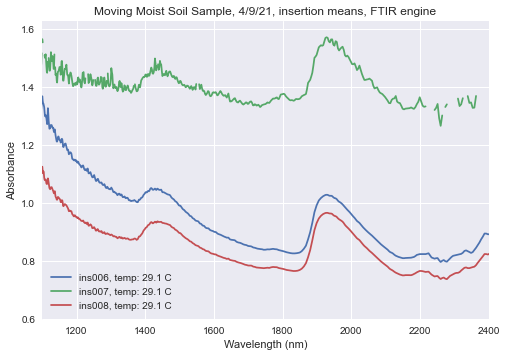

In [25]:
fig, ax = plt.subplots()
# ax.set_ylim(0.35, 0.75)
ax.set_xlim(1100, 2400)
ax.set_ylabel("Absorbance")
ax.set_xlabel("Wavelength (nm)")
ax.set_title("Moving Moist Soil Sample, 4/9/21, insertion means, FTIR engine")
for insertion in insertions_4_09_moving:
    insertion_path = f'{calibration_4_09_moving[0]}/{insertion}'
    ins_temp = get_insertion_temperature(file, insertion_path)
    label = f'{insertion}, temp: {ins_temp:0.1f} C'
    ins_abs = get_ftir_insertion_absorbances(file, insertion_path)
    ax.plot(ftir_waves, ins_abs.mean(axis=0), label=label)
ax.legend()
plt.show()
plt.close()

# Spectra obtained 4/21/21

Here I was primarily looking to determine how temperature affects the spectra. 

Beginning on this date, the calibration and insertion temperatures are correctly recorded in the dataset.

In [26]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
test_file_name = "210421_green_tests/green_testing_210421.h5"
file = path_name + test_file_name
calibrations = ['session001/cal001', 'session001/cal002', 'session001/cal003', 'session001/cal004', 'session001/cal005']


In [27]:
calibrations = create_list_of_calibrations_in_node(file, "/")

In [28]:
for calibration in calibrations:
    insertions = create_list_of_insertions_in_calibration(file, calibration)


In [29]:
for calibration in calibrations:
    insertions = create_list_of_insertions_in_calibration(file, calibration)
    for insertion in insertions:
        insertion_path = f'{calibration}/{insertion}'
        insertion_temp = get_insertion_temperature(file, insertion_path)


# Calibration spectra from 4/21/21

The spectra are plotted with color varying by temperature:  high temp is at the purple end of the color palette, and low temps are yellow-green.

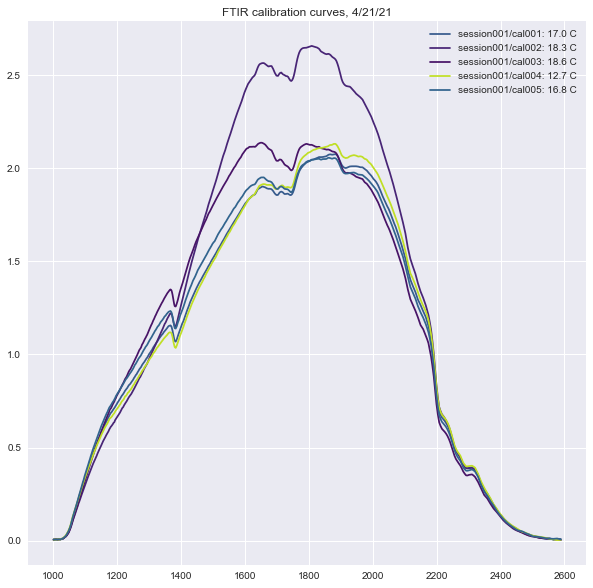

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR calibration curves, 4/21/21")
for calibration in calibrations:
    cal_temp = get_calibration_temperature(file, calibration)
    color = plt.cm.viridis((cal_temp - 19.0)/(12.0 - 19.0))
    ftir_cal = get_ftir_white_calibration_curve(file, calibration)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ftir_cal, color=color, label=f'{calibration}: {cal_temp:0.1f} C')
ax.legend()
plt.show()
plt.close()

In [31]:
blank_insertions = ['ins001', 'ins002', 'ins003', 'ins004', 'ins005', 'ins006',
                   'ins008', 'ins014', 'ins015', 'ins021', 'ins022', 'ins029', 'ins030']

soil_insertions = ['ins007', 'ins009', 'ins010', 'ins011', 'ins012',  'ins013', 'ins016',
                   'ins017',  'ins018',  'ins019',  'ins020',  'ins023',  'ins024',  'ins025',
                    'ins026', 'ins027',  'ins028']

# Absorbance spectra of white test blank

A large number of "insertions" of the white test blank with the stationary probe were collected at various times during the morning.

Here the absorbance spectra are plotted.  The line color changes with each calibration.  Temperature of the insertion is noted.

During calibration cal003 the rig was moved outside the garage in order to expose the spectrometer to more extreme temperatures (colder).  It was moved back inside during calibration cal004.

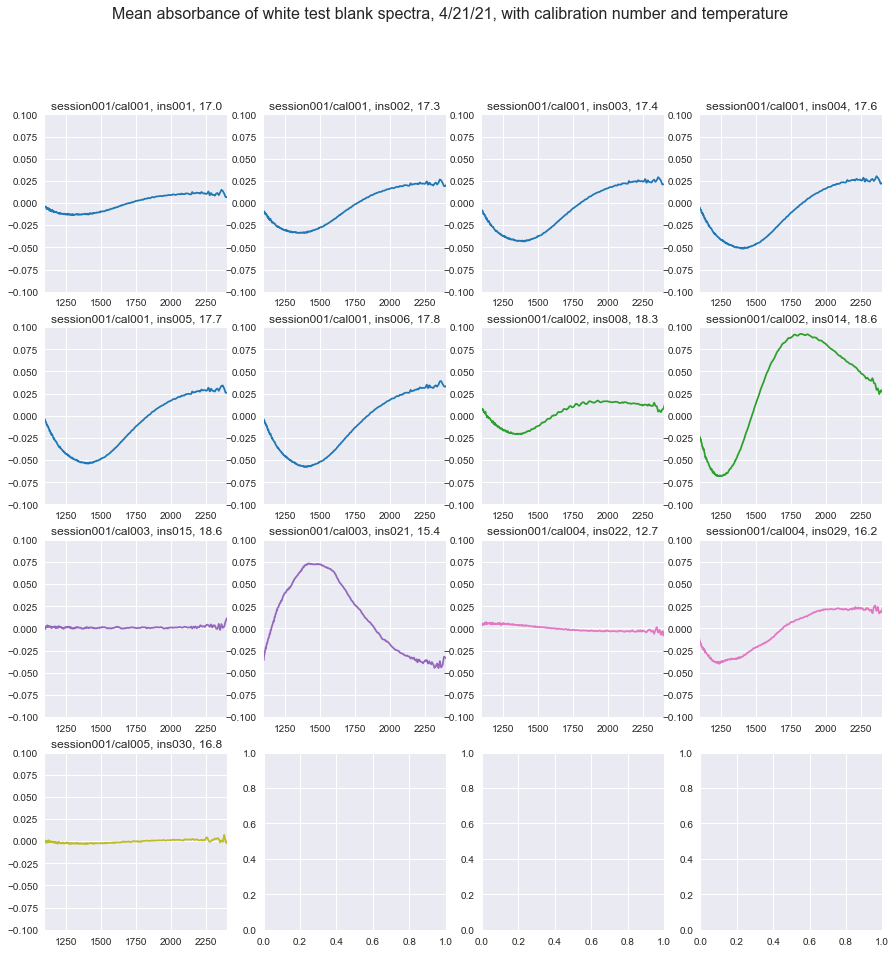

In [32]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
fig.suptitle("Mean absorbance of white test blank spectra, 4/21/21, with calibration number and temperature", fontsize=16)

for calibration in calibrations:
    cal_index = calibrations.index(calibration)
    color = plt.cm.tab10(cal_index/len(calibrations))
    insertions = create_list_of_insertions_in_calibration(file, calibration)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    for insertion in insertions:
        insertion_path = f'{calibration}/{insertion}'
        insertion_temp = get_insertion_temperature(file, insertion_path)
        ins_abs = get_ftir_insertion_absorbances(file, insertion_path)
        if insertion in blank_insertions:
            index = blank_insertions.index(insertion)
            axs.flat[index].set_ylim(-0.1, 0.1)
            axs.flat[index].set_xlim(1100, 2400)
            axs.flat[index].set_title(f'{calibration}, {insertion}, {insertion_temp:0.1f}')
            axs.flat[index].plot(ftir_waves, ins_abs.mean(axis=0), color=color)
ax.legend()
plt.show()
plt.close()
    
    

## Absorbance spectra of moist soil sample

A large number of "insertions" of the moist soil sample with the stationary probe were collected at various times during the morning.

Here the absorbance spectra are plotted. The line color changes with each calibration. Temperature of the insertion is noted.

During calibration cal003 the rig was moved outside the garage in order to expose the spectrometer to more extreme temperatures (colder). It was moved back inside during calibration cal004.

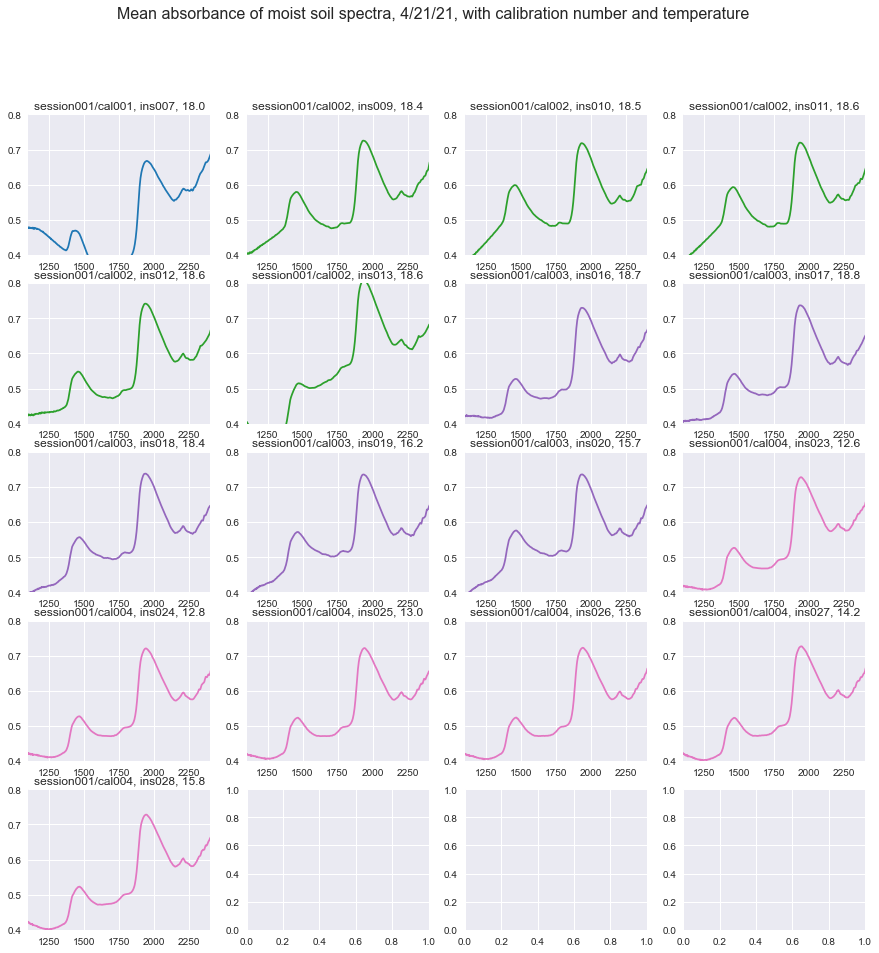

In [33]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
fig.suptitle("Mean absorbance of moist soil spectra, 4/21/21, with calibration number and temperature", fontsize=16)
for calibration in calibrations:
    cal_index = calibrations.index(calibration)
    color = plt.cm.tab10(cal_index/len(calibrations))
    insertions = create_list_of_insertions_in_calibration(file, calibration)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    for insertion in insertions:
        insertion_path = f'{calibration}/{insertion}'
        insertion_temp = get_insertion_temperature(file, insertion_path)
        ins_abs = get_ftir_insertion_absorbances(file, insertion_path)
        if insertion in soil_insertions:
            index = soil_insertions.index(insertion)
            axs.flat[index].set_ylim(0.4, 0.8)
            axs.flat[index].set_xlim(1100, 2400)
            axs.flat[index].set_title(f'{calibration}, {insertion}, {insertion_temp:0.1f}')
            axs.flat[index].plot(ftir_waves, ins_abs.mean(axis=0), color=color)
ax.legend()
plt.show()
plt.close()

# Absorbance spectra of white test blank, visible spectrometer

A large number of "insertions" of the white test blank with the stationary probe were collected at various times during the morning.

Here the absorbance spectra are plotted.  The line color changes with each calibration.  Temperature of the insertion is noted.

During calibration cal003 the rig was moved outside the garage in order to expose the spectrometer to more extreme temperatures (colder).  It was moved back inside during calibration cal004.

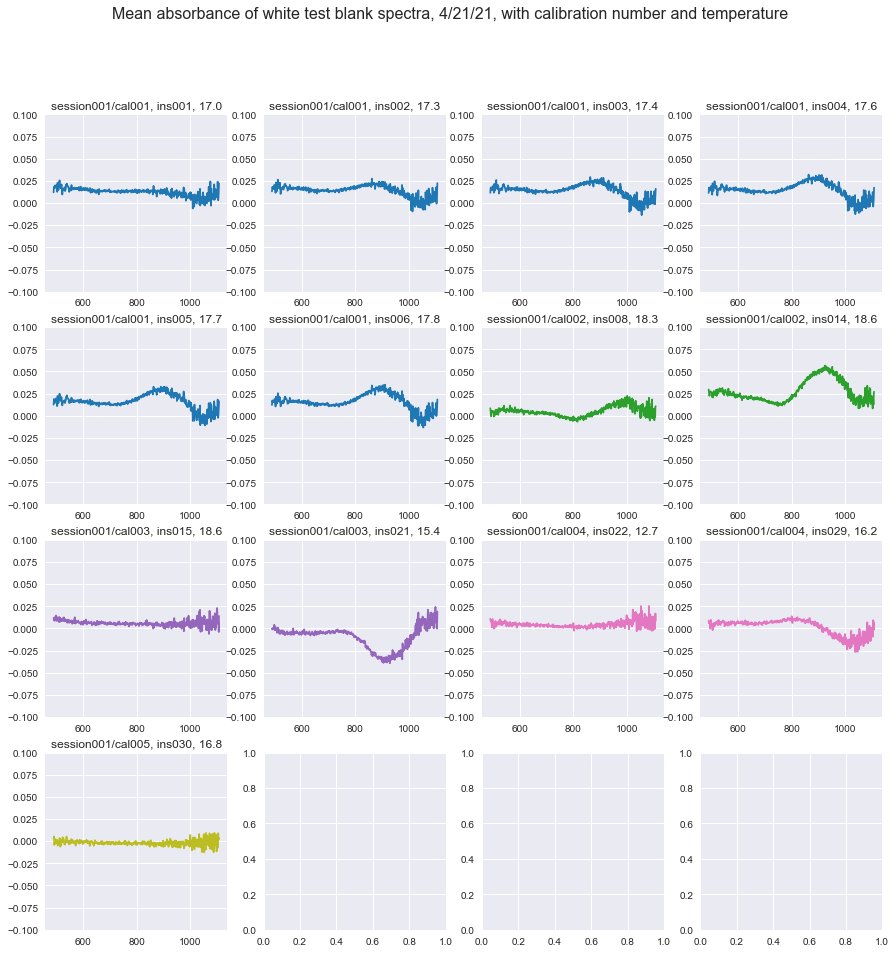

In [34]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
fig.suptitle("Mean absorbance of white test blank spectra, 4/21/21, with calibration number and temperature", fontsize=16)
for calibration in calibrations:
    cal_index = calibrations.index(calibration)
    color = plt.cm.tab10(cal_index/len(calibrations))
    insertions = create_list_of_insertions_in_calibration(file, calibration)
    vis_waves = get_visible_wavelength_vector(file, calibration)
    for insertion in insertions:
        insertion_path = f'{calibration}/{insertion}'
        insertion_temp = get_insertion_temperature(file, insertion_path)
        ins_abs = get_visible_insertion_absorbances(file, insertion_path)
        if insertion in blank_insertions:
            index = blank_insertions.index(insertion)
            axs.flat[index].set_ylim(-0.1, 0.1)
            axs.flat[index].set_title(f'{calibration}, {insertion}, {insertion_temp:0.1f}')
            axs.flat[index].plot(vis_waves, ins_abs.mean(axis=0), color=color)
ax.legend()
plt.show()
plt.close()

## Absorbance spectra of moist soil sample, visible spectrometer

A large number of "insertions" of the moist soil sample with the stationary probe were collected at various times during the morning.

Here the absorbance spectra are plotted. The line color changes with each calibration. Temperature of the insertion is noted.

During calibration cal003 the rig was moved outside the garage in order to expose the spectrometer to more extreme temperatures (colder). It was moved back inside during calibration cal004.

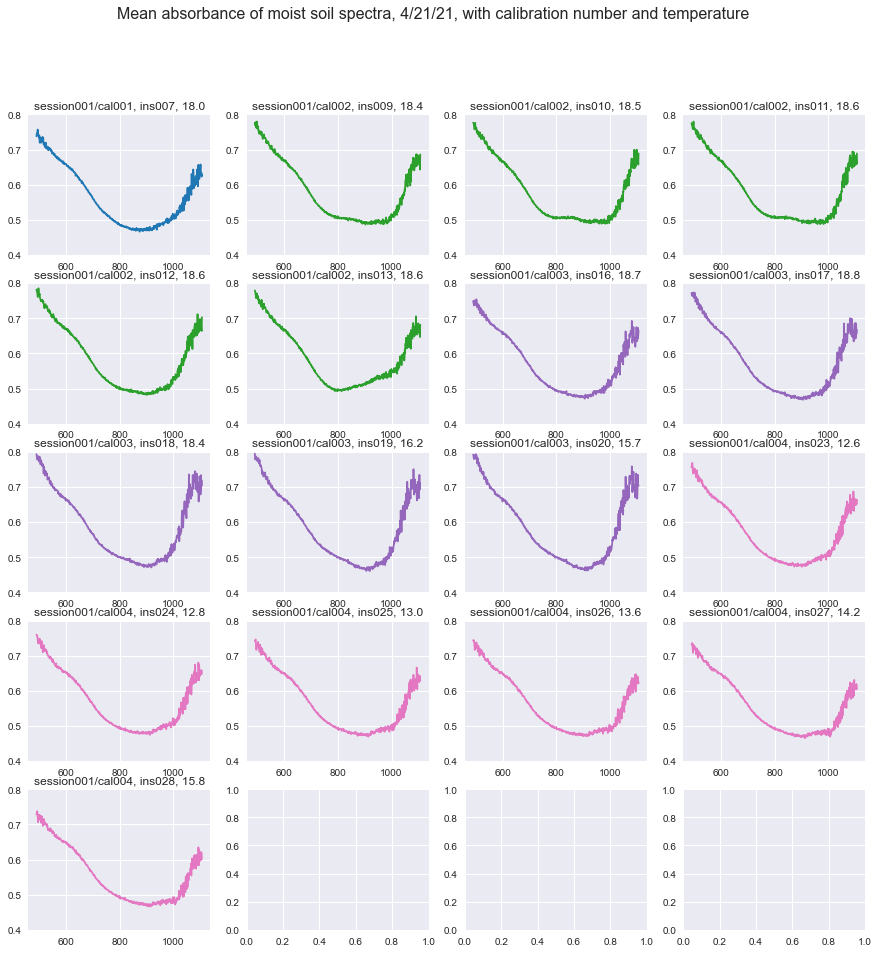

In [35]:
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
fig.suptitle("Mean absorbance of moist soil spectra, 4/21/21, with calibration number and temperature", fontsize=16)
for calibration in calibrations:
    cal_index = calibrations.index(calibration)
    color = plt.cm.tab10(cal_index/len(calibrations))
    insertions = create_list_of_insertions_in_calibration(file, calibration)
    vis_waves = get_visible_wavelength_vector(file, calibration)
    for insertion in insertions:
        insertion_path = f'{calibration}/{insertion}'
        insertion_temp = get_insertion_temperature(file, insertion_path)
        ins_abs = get_visible_insertion_absorbances(file, insertion_path)
        if insertion in soil_insertions:
            index = soil_insertions.index(insertion)
            axs.flat[index].set_ylim(0.4, 0.8)
            axs.flat[index].set_title(f'{calibration}, {insertion}, {insertion_temp:0.1f}')
            axs.flat[index].plot(vis_waves, ins_abs.mean(axis=0), color=color)
ax.legend()
plt.show()
plt.close()

# Raw spectra of white test blank, FTIR engine, 4/21/21

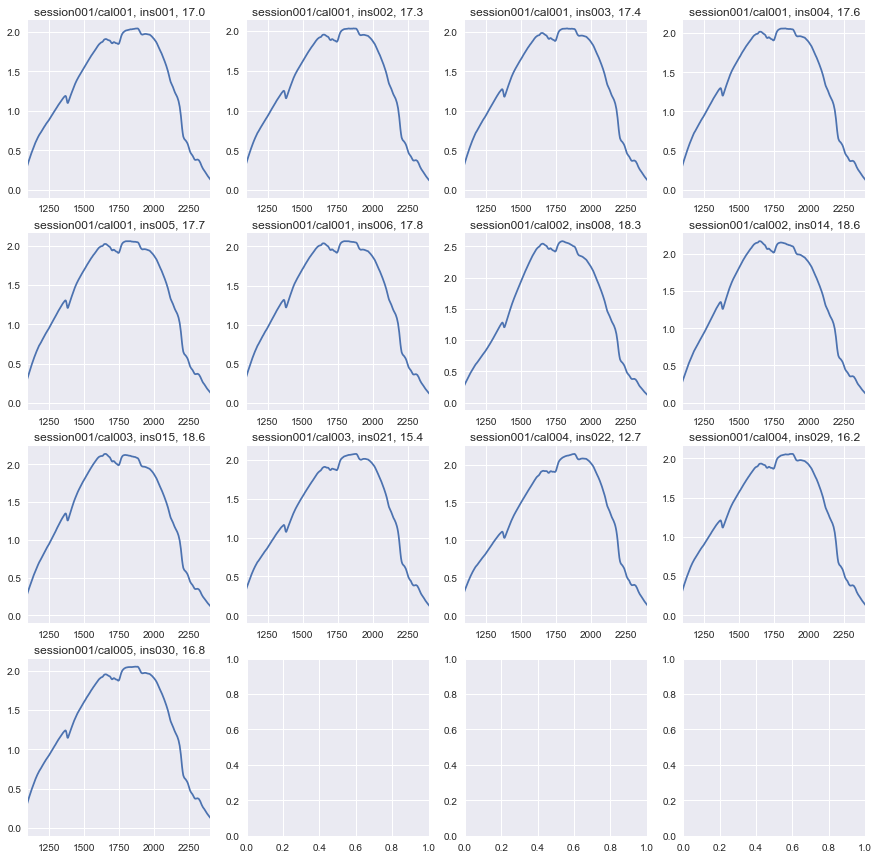

In [36]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for calibration in calibrations:
    insertions = create_list_of_insertions_in_calibration(file, calibration)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    for insertion in insertions:
        insertion_path = f'{calibration}/{insertion}'
        insertion_temp = get_insertion_temperature(file, insertion_path)
        ins_raw = get_ftir_insertion_raw_spectra(file, insertion_path)
        if insertion in blank_insertions:
            index = blank_insertions.index(insertion)

            axs.flat[index].set_xlim(1100, 2400)
            axs.flat[index].set_title(f'{calibration}, {insertion}, {insertion_temp:0.1f}')
            axs.flat[index].plot(ftir_waves, ins_raw.mean(axis=0))
ax.legend()
plt.show()
plt.close()

# Plot of both calibration and white blank curves, FTIR engine, 4/21/21, with color by temperature

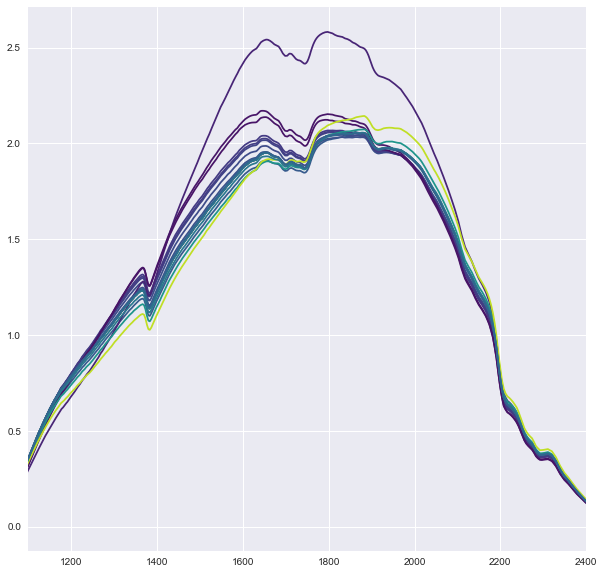

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(1100, 2400)
for calibration in calibrations:
    insertions = create_list_of_insertions_in_calibration(file, calibration)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    ax.plot(ftir_waves, ftir_cal, color=color, label=f'{calibration}: {cal_temp:0.1f} C')
    for insertion in insertions:
        insertion_path = f'{calibration}/{insertion}'
        insertion_temp = get_insertion_temperature(file, insertion_path)
        color = plt.cm.viridis((insertion_temp - 19.0)/(12.0 - 19.0))
        ins_raw = get_ftir_insertion_raw_spectra(file, insertion_path)
        if insertion in blank_insertions:
            index = blank_insertions.index(insertion)
            ax.plot(ftir_waves, ins_raw.mean(axis=0), color=color)

plt.show()
plt.close()

# Raw spectra of white test blank, visible spectrometer, 4/21/21

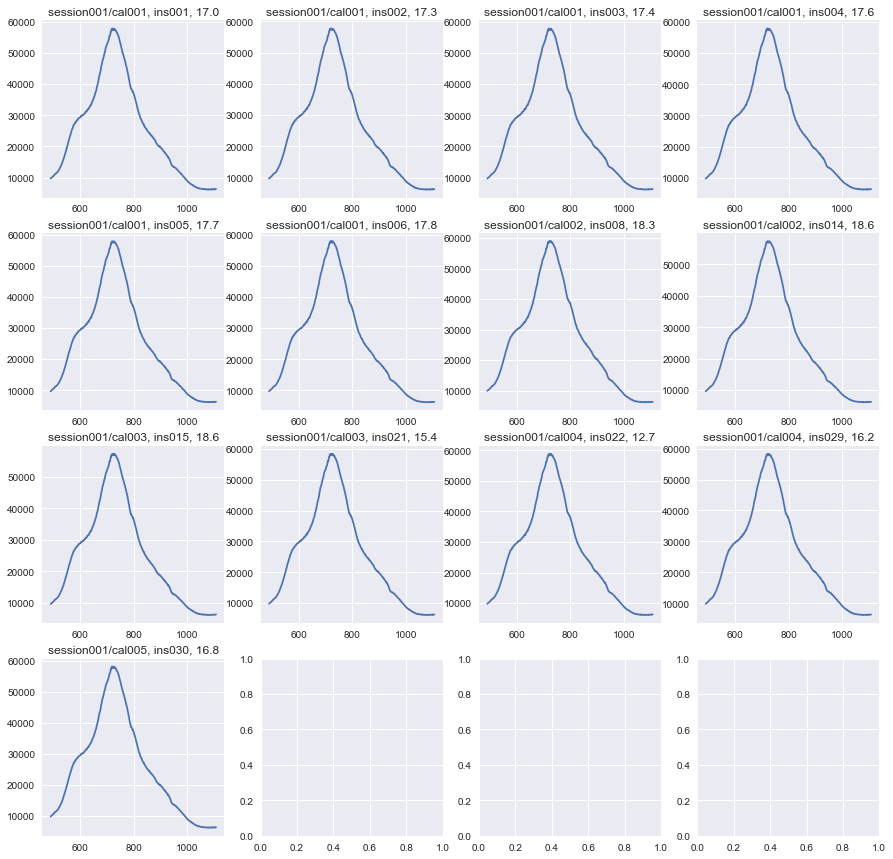

In [38]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for calibration in calibrations:
    insertions = create_list_of_insertions_in_calibration(file, calibration)
    vis_waves = get_visible_wavelength_vector(file, calibration)
    for insertion in insertions:
        insertion_path = f'{calibration}/{insertion}'
        insertion_temp = get_insertion_temperature(file, insertion_path)
        ins_raw = get_visible_insertion_raw_spectra(file, insertion_path)
        if insertion in blank_insertions:
            index = blank_insertions.index(insertion)

            axs.flat[index].set_title(f'{calibration}, {insertion}, {insertion_temp:0.1f}')
            axs.flat[index].plot(vis_waves, ins_raw.mean(axis=0))
ax.legend()
plt.show()
plt.close()

## Offset plot of absorbance of moist soil samples collected 4/21/21

Color here is determined by the insertion temperature (purple = high temp, yellow green = low temp)

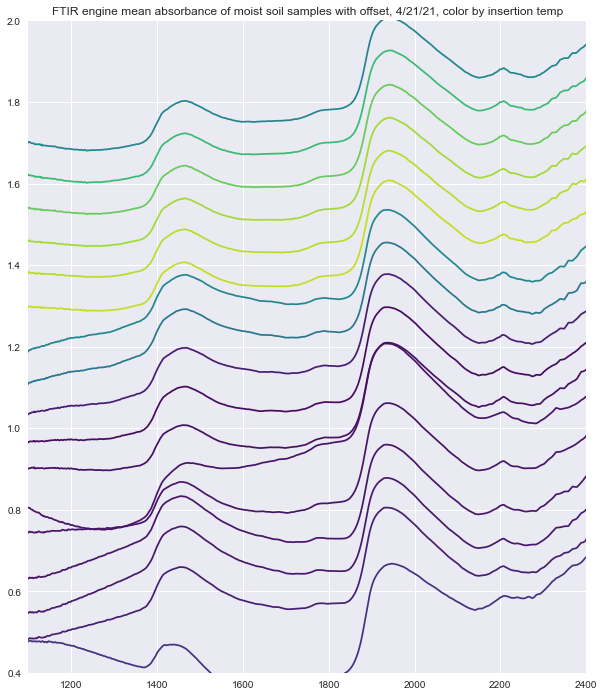

In [39]:
fig, ax = plt.subplots(figsize=(10, 12))
ax.set_xlim(1100, 2400)
ax.set_ylim(0.4, 2.0)
ax.set_title("FTIR engine mean absorbance of moist soil samples with offset, 4/21/21, color by insertion temp")
i = 0

for calibration in calibrations:    
    insertions = create_list_of_insertions_in_calibration(file, calibration)
    ftir_waves = get_ftir_wavelength_vector(file, calibration)
    for insertion in insertions:
        insertion_path = f'{calibration}/{insertion}'
        insertion_temp = get_insertion_temperature(file, insertion_path)
        color = plt.cm.viridis((insertion_temp - 19.0)/(12.0 - 19.0))
        ins_abs = get_ftir_insertion_absorbances(file, insertion_path)
        if insertion in soil_insertions:
            offset = i * 0.08
            ax.plot(ftir_waves, ins_abs.mean(axis=0) + offset, color=color)
            i += 1
plt.show()
plt.close()
